In [1]:
import pandas as pd
import numpy as np
import time
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

import biomart
import prototypical_network
import helper_fns
import vanilla_vae
from model import PL, Net, train

In [2]:
dataset_celltypist = sc.read("/Volumes/SSD/global.h5ad")
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
list_celltypes = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_celltypes = list(filter(lambda x: x not in ['Mast cells', 'pDC','Progenitor', 'Erythroid', 'Megakaryocytes'], list_celltypes))
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_celltypes))
dataset_celltypist = dataset_celltypist[dataset_celltypist.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_celltypist.obs['Manually_curated_celltype'])

list_ct = dataset_celltypist.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

g = helper_fns.build_hierarchical_tree_celltypist(all_nodes=all_nodes, list_ct=list_ct, list_inner_nodes=list_inner_nodes, encoder_celltype=encoder_celltype, encoder_celltype_inner=encoder_celltype_inner)

dist_df = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(dist_df.values, dtype=float)
ensembl_to_genesymbol = helper_fns.get_ensembl_mappings()

genes_celltypist = dataset_celltypist.var_names
genes_popv = dataset_popv.var_names
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

# filter the anndata by the found_ensembl genes
dataset_popv = dataset_popv[:,found_ensembl]
dataset_celltypist = dataset_celltypist[:,found_hgnc]

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_celltypist, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset_celltypist, 1e4)
sc.pp.log1p(dataset_celltypist)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset_celltypist[train_indices].X)
dataset_celltypist_pca = AnnData(pca.transform(dataset_celltypist.X))
dataset_celltypist_pca.obs = dataset_celltypist.obs

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset_celltypist_pca, batch_size=512, convert=encoders, sampler=test_subsampler)


# Label encoder // No problem
encoder_celltype_popv = LabelEncoder()
encoder_celltype_popv.fit(dataset_popv.obs['cell_type'])

sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset_popv.obs

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/xbh0403/Desktop/HCell/model.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  centers = torch.tensor(centers, dtype=float)


Epoch 1
Train ER 53.57, time 6.1s
Test ER 35.83, time 0.5s
Epoch 2
Train ER 30.36, time 5.3s
Test ER 25.33, time 0.5s
Epoch 3
Train ER 25.72, time 5.3s
Test ER 22.02, time 0.5s
Epoch 4
Train ER 22.14, time 5.2s
Test ER 20.42, time 0.6s
Epoch 5
Train ER 19.49, time 5.3s
Test ER 19.52, time 0.5s
Epoch 6
Train ER 17.63, time 5.2s
Test ER 17.54, time 0.6s
Epoch 7
Train ER 16.32, time 5.3s
Test ER 16.15, time 0.6s
Epoch 8
Train ER 15.20, time 5.4s
Test ER 15.06, time 0.5s
Epoch 9
Train ER 14.26, time 5.3s
Test ER 13.97, time 0.5s
Epoch 10
Train ER 13.52, time 5.2s
Test ER 13.51, time 0.6s
Epoch 11
Train ER 13.00, time 5.3s
Test ER 13.17, time 0.6s
Epoch 12
Train ER 12.57, time 5.3s
Test ER 12.75, time 0.5s
Epoch 13
Train ER 12.20, time 5.2s
Test ER 12.44, time 0.6s
Epoch 14
Train ER 11.88, time 5.3s
Test ER 12.24, time 0.5s
Epoch 15
Train ER 11.61, time 5.3s
Test ER 11.99, time 0.5s
Epoch 16
Train ER 11.45, time 5.3s
Test ER 11.84, time 0.6s
Epoch 17
Train ER 11.26, time 5.3s
Test ER 11.69,

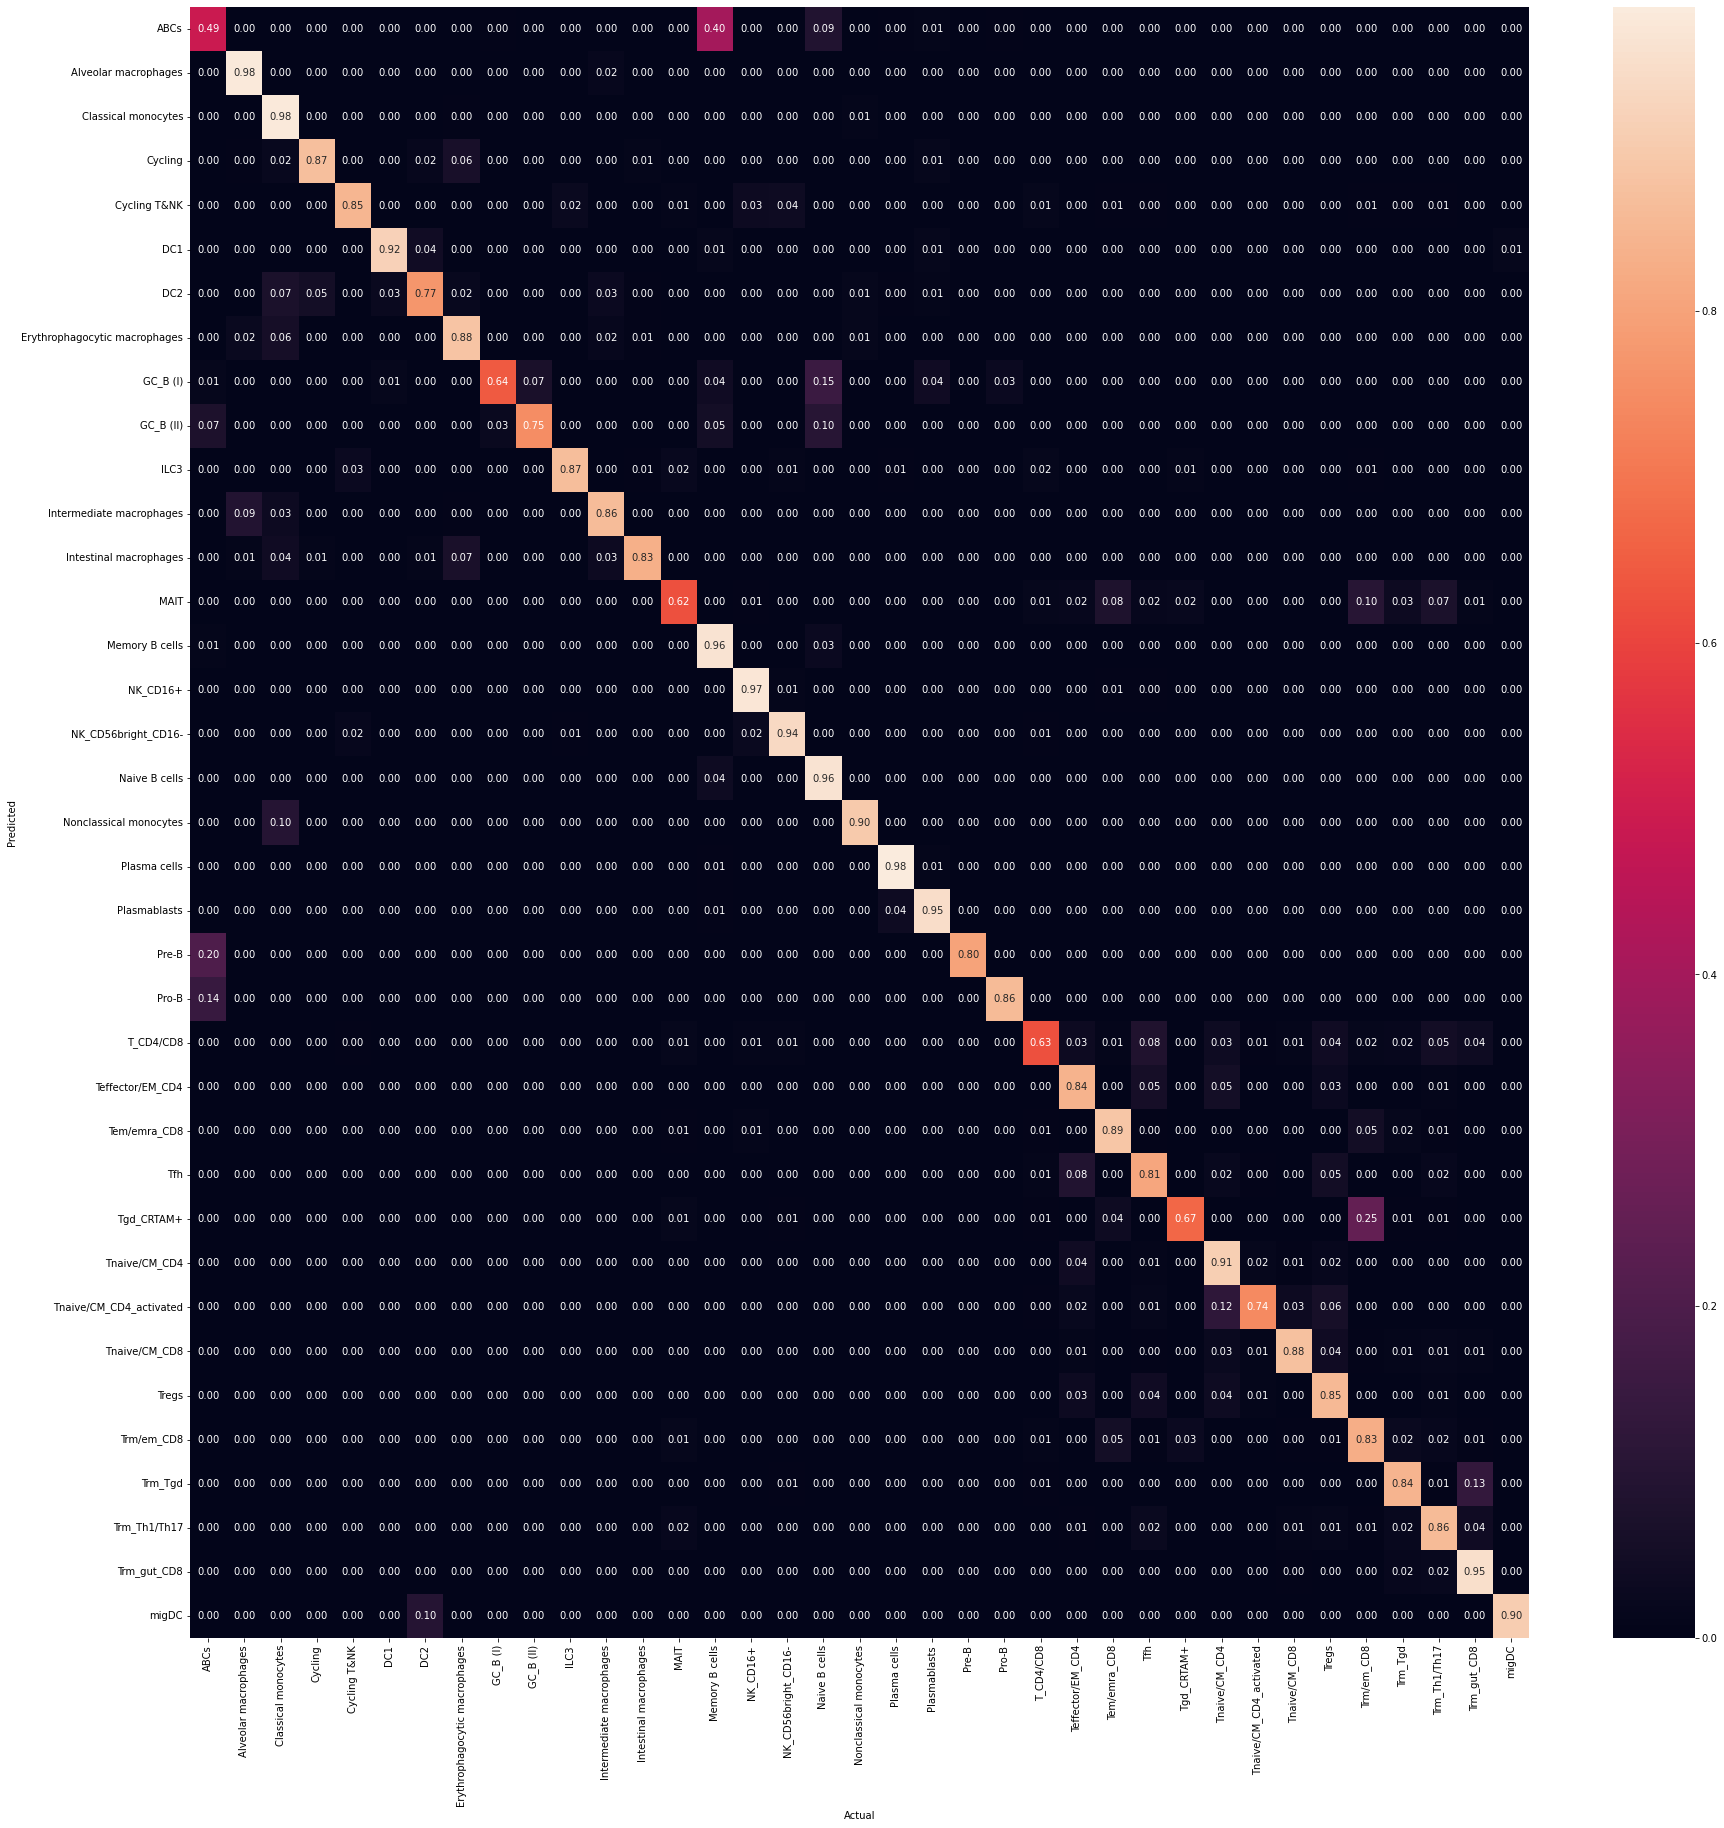

In [3]:
weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_celltypist, encoder=encoder_celltype, obs='Manually_curated_celltype')
model = train(mode='Proto_Net', loss_mode='disto_pl', epochs=50, embedding_dim=2, D=D, num_celltypes=list_num_ct, 
    encoder=encoder_celltype, dataset=dataset_celltypist_pca, dataloader_training=dataloader_training, dataloader_testing=dataloader_testing, 
    obs_name='Manually_curated_celltype', init_weights=weights)
embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))
helper_fns.plot_confusion_matrix('Proto_Net', model, dataset=dataset_celltypist_pca, encoder=encoder_celltype, test_indices=test_indices)

In [4]:
train_embeddings, training_preds = helper_fns.get_embeddings_and_out(model, dataset_celltypist_pca[train_indices], encoder=encoder_celltype)
test_embeddings, test_preds = helper_fns.get_embeddings_and_out(model, dataset_popv_pca, encoder=encoder_celltype)
prototypes, prototypes_labels = helper_fns.get_prototypes_and_labels(model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

True positive memory B cell: 94.15029344220464%
{'Tgd_CRTAM+': 76, 'Naive B cells': 315, 'Plasma cells': 135, 'Plasmablasts': 72, 'ABCs': 65, 'T_CD4/CD8': 13, 'Trm_Th1/Th17': 13, 'Tfh': 28, 'Tregs': 29, 'Trm/em_CD8': 45, 'Trm_Tgd': 2, 'MAIT': 21, 'Tem/emra_CD8': 8, 'Tnaive/CM_CD8': 2, 'Teffector/EM_CD4': 1, 'Pre-B': 1, 'GC_B (II)': 7, 'Tnaive/CM_CD4': 1, 'Cycling': 18, 'Intermediate macrophages': 3, 'Intestinal macrophages': 12, 'NK_CD56bright_CD16-': 2, 'Erythrophagocytic macrophages': 3, 'ILC3': 30, 'Cycling T&NK': 4, 'GC_B (I)': 6, 'DC2': 5}


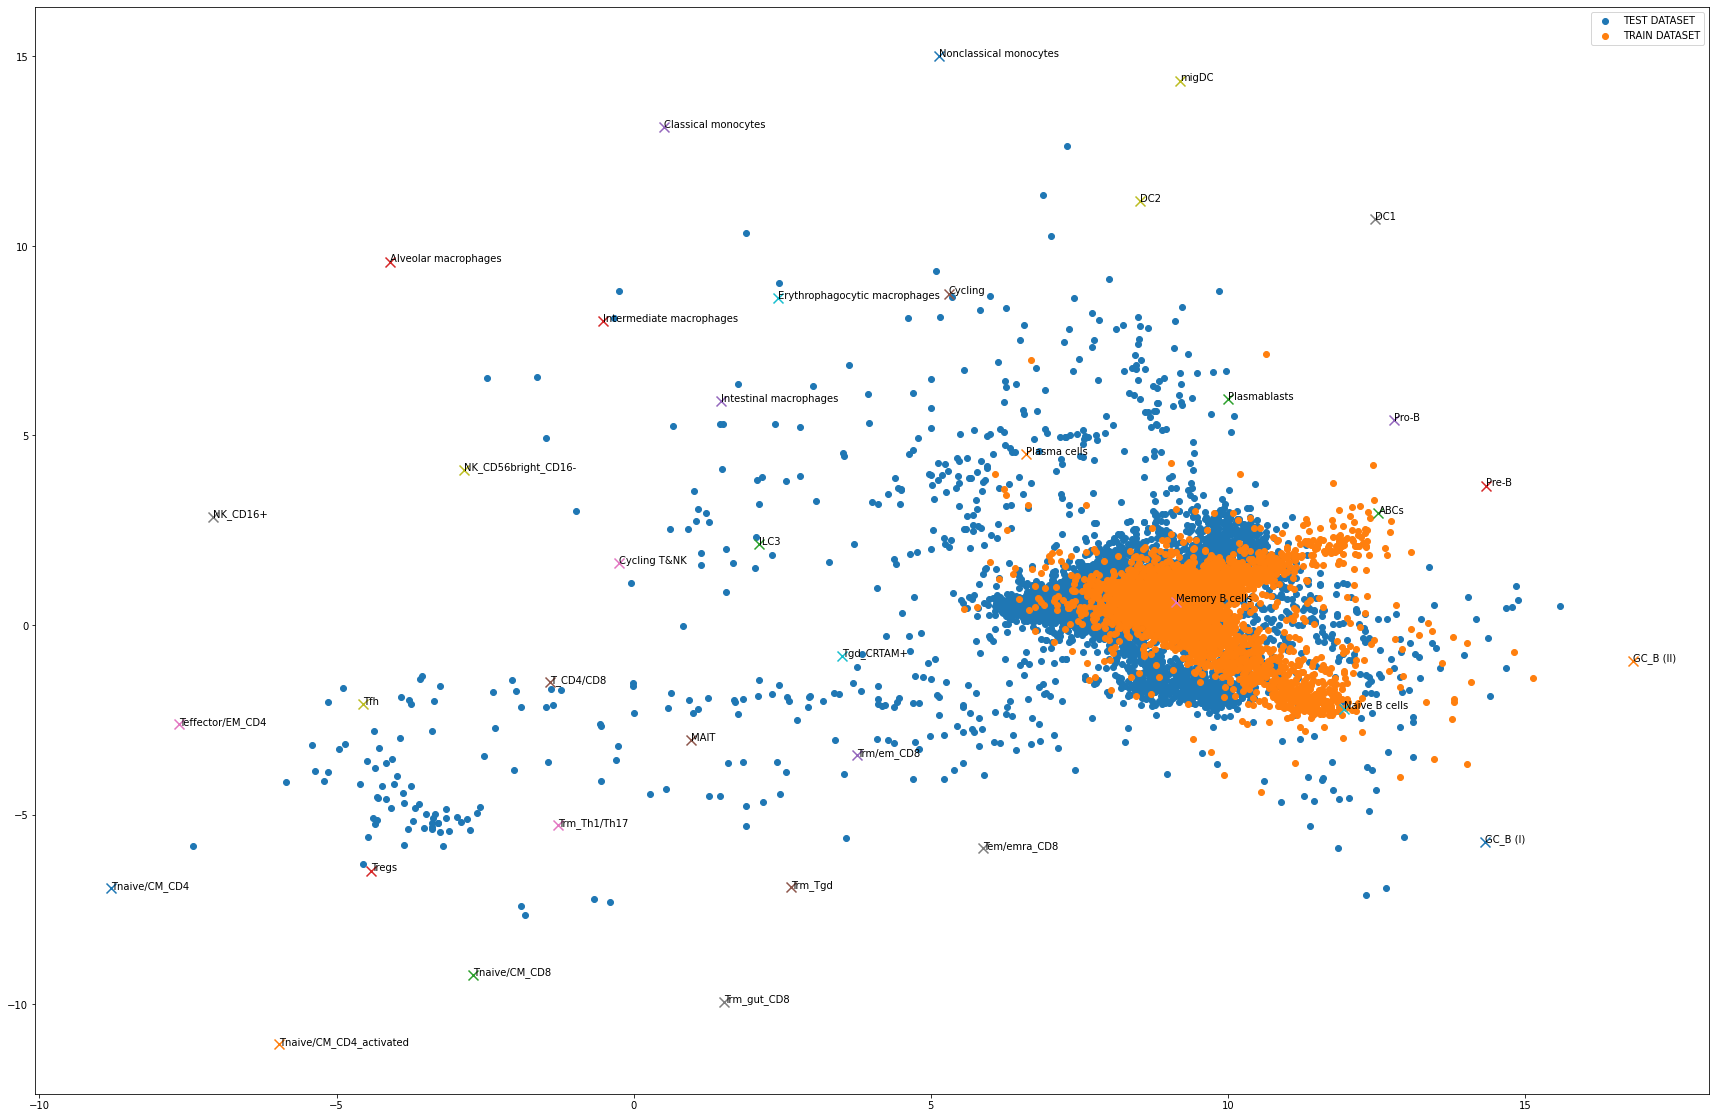

In [5]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Memory B cells', test_celltype='memory B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive naive B cell: 67.13503919538529%
{'Memory B cells': 2176, 'ABCs': 9, 'Plasmablasts': 8, 'NK_CD56bright_CD16-': 2, 'Trm/em_CD8': 2, 'Tgd_CRTAM+': 7, 'Cycling': 1, 'Plasma cells': 8, 'ILC3': 1, 'Tregs': 2, 'T_CD4/CD8': 2, 'Trm_Tgd': 1, 'MAIT': 1, 'Intermediate macrophages': 2}


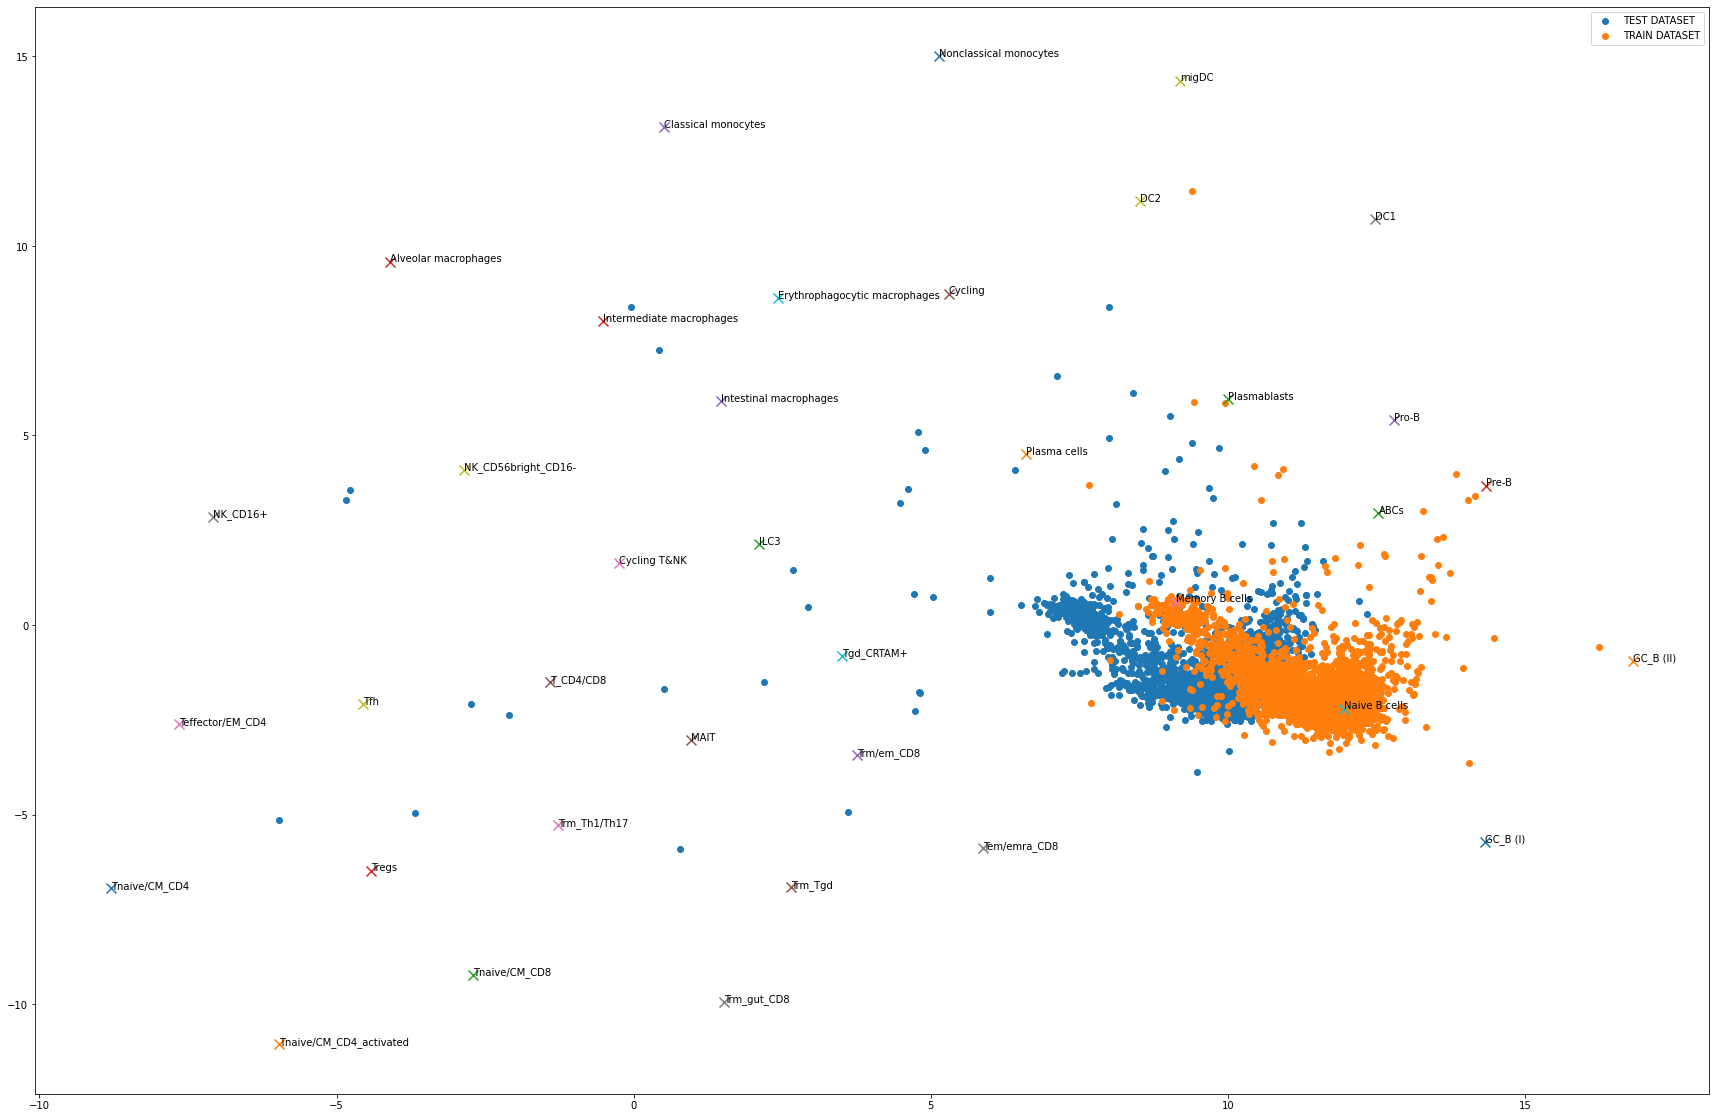

In [6]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Naive B cells', test_celltype='naive B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive T follicular helper cell: 41.45728643216081%
{'Tnaive/CM_CD4': 104, 'Teffector/EM_CD4': 67, 'Trm_Th1/Th17': 24, 'Tregs': 20, 'Tnaive/CM_CD8': 4, 'Trm_Tgd': 2, 'T_CD4/CD8': 11, 'MAIT': 1}


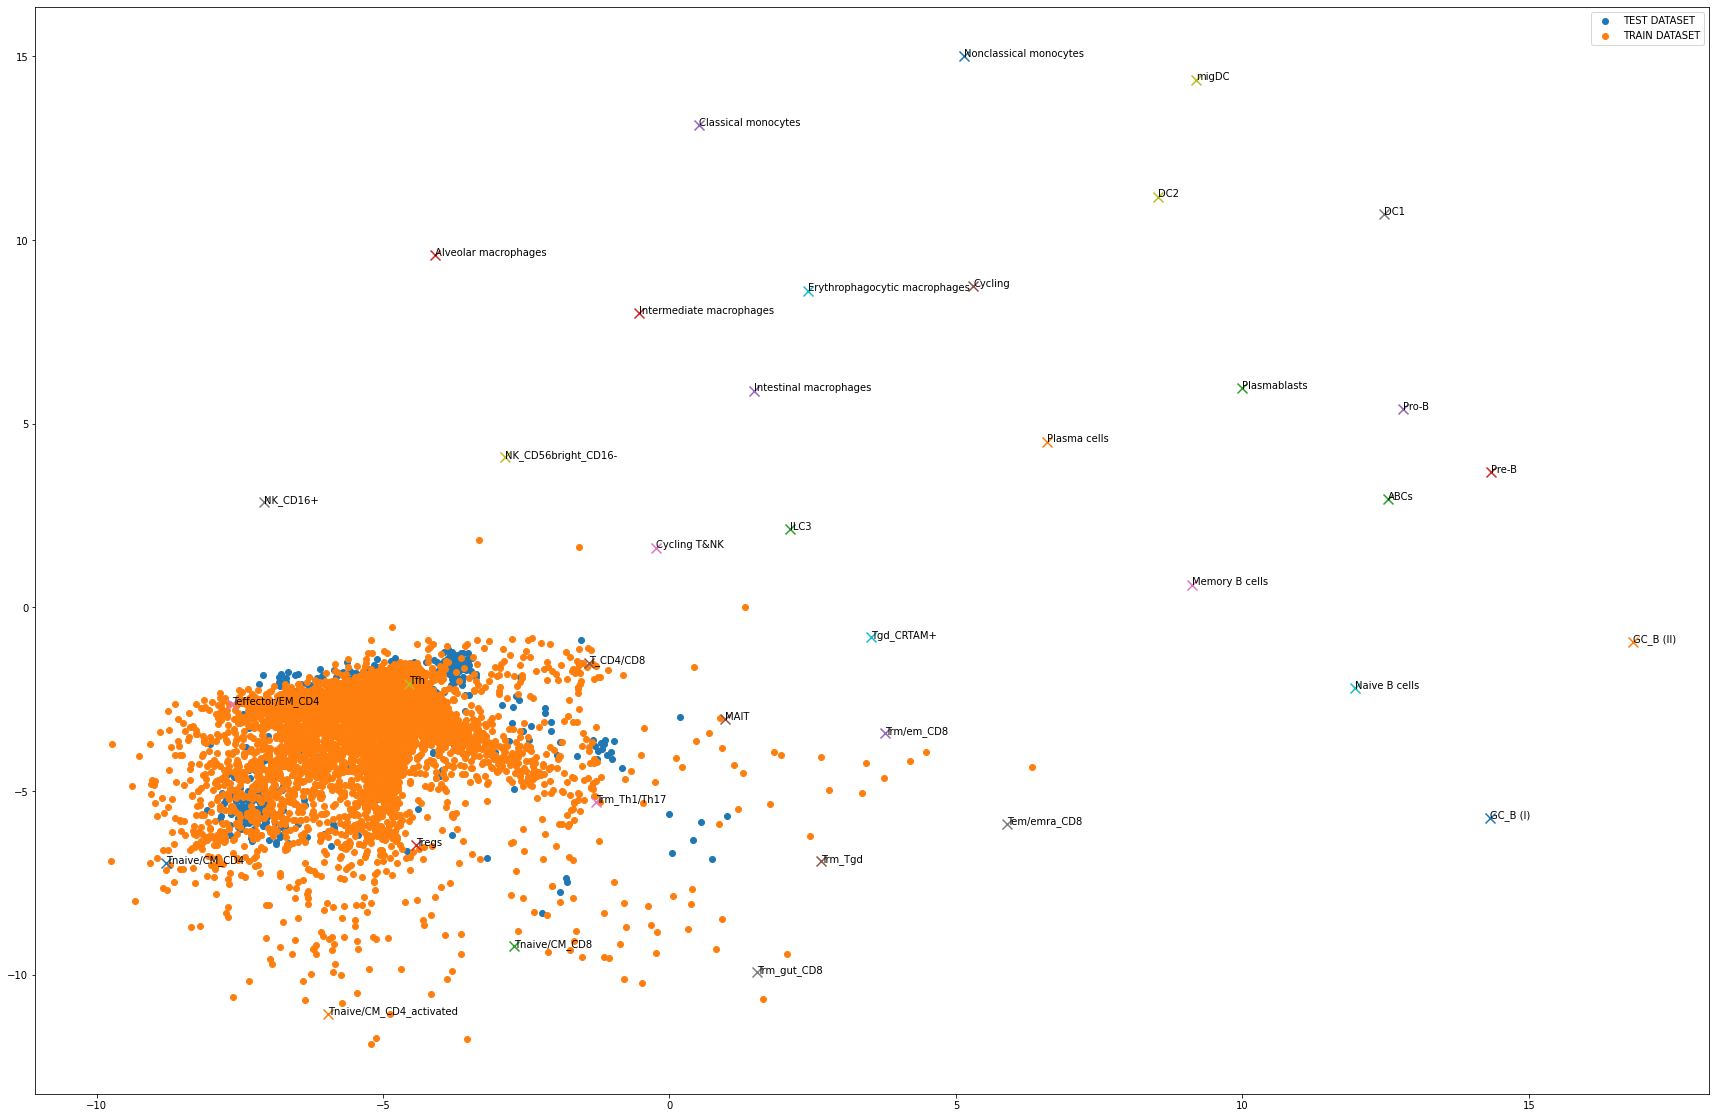

In [7]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Tfh', test_celltype='T follicular helper cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive plasma cell: 72.30835859679516%
{'Memory B cells': 37, 'Naive B cells': 4, 'Plasmablasts': 2173, 'Cycling': 3, 'Erythrophagocytic macrophages': 3, 'Intestinal macrophages': 13, 'Pro-B': 166, 'ABCs': 25, 'NK_CD56bright_CD16-': 65, 'ILC3': 192, 'Cycling T&NK': 13, 'Tgd_CRTAM+': 6, 'Intermediate macrophages': 4, 'GC_B (I)': 1, 'Trm/em_CD8': 2, 'NK_CD16+': 472, 'Tem/emra_CD8': 3, 'T_CD4/CD8': 2, 'Tfh': 2, 'Trm_Th1/Th17': 3, 'MAIT': 2, 'Alveolar macrophages': 5, 'DC2': 1}


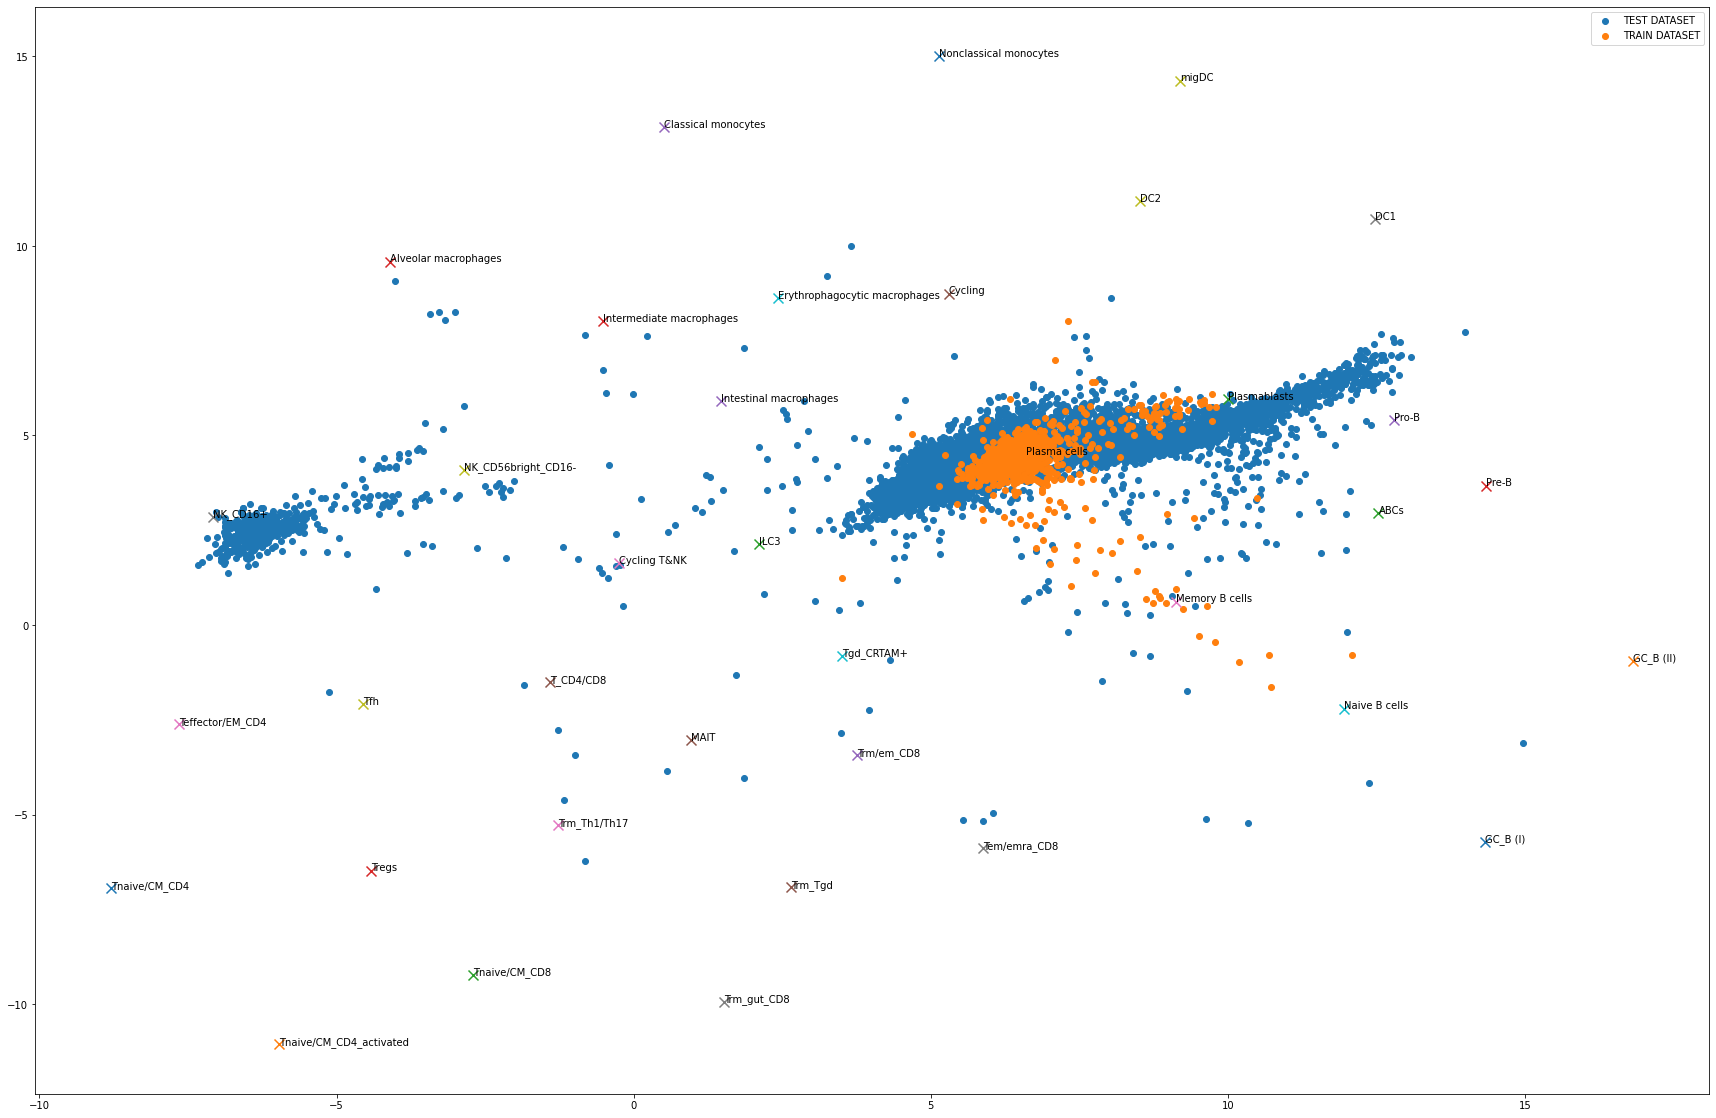

In [8]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Plasma cells', test_celltype='plasma cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

True positive regulatory T cell: 58.0199539524175%
{'Memory B cells': 8, 'Trm_Th1/Th17': 300, 'Tnaive/CM_CD8': 1, 'Tfh': 94, 'Trm/em_CD8': 23, 'Tem/emra_CD8': 6, 'Cycling T&NK': 68, 'Tgd_CRTAM+': 10, 'Teffector/EM_CD4': 8, 'T_CD4/CD8': 11, 'MAIT': 9, 'Tnaive/CM_CD4': 1, 'Intestinal macrophages': 1, 'Trm_Tgd': 1, 'ILC3': 4, 'NK_CD56bright_CD16-': 2}


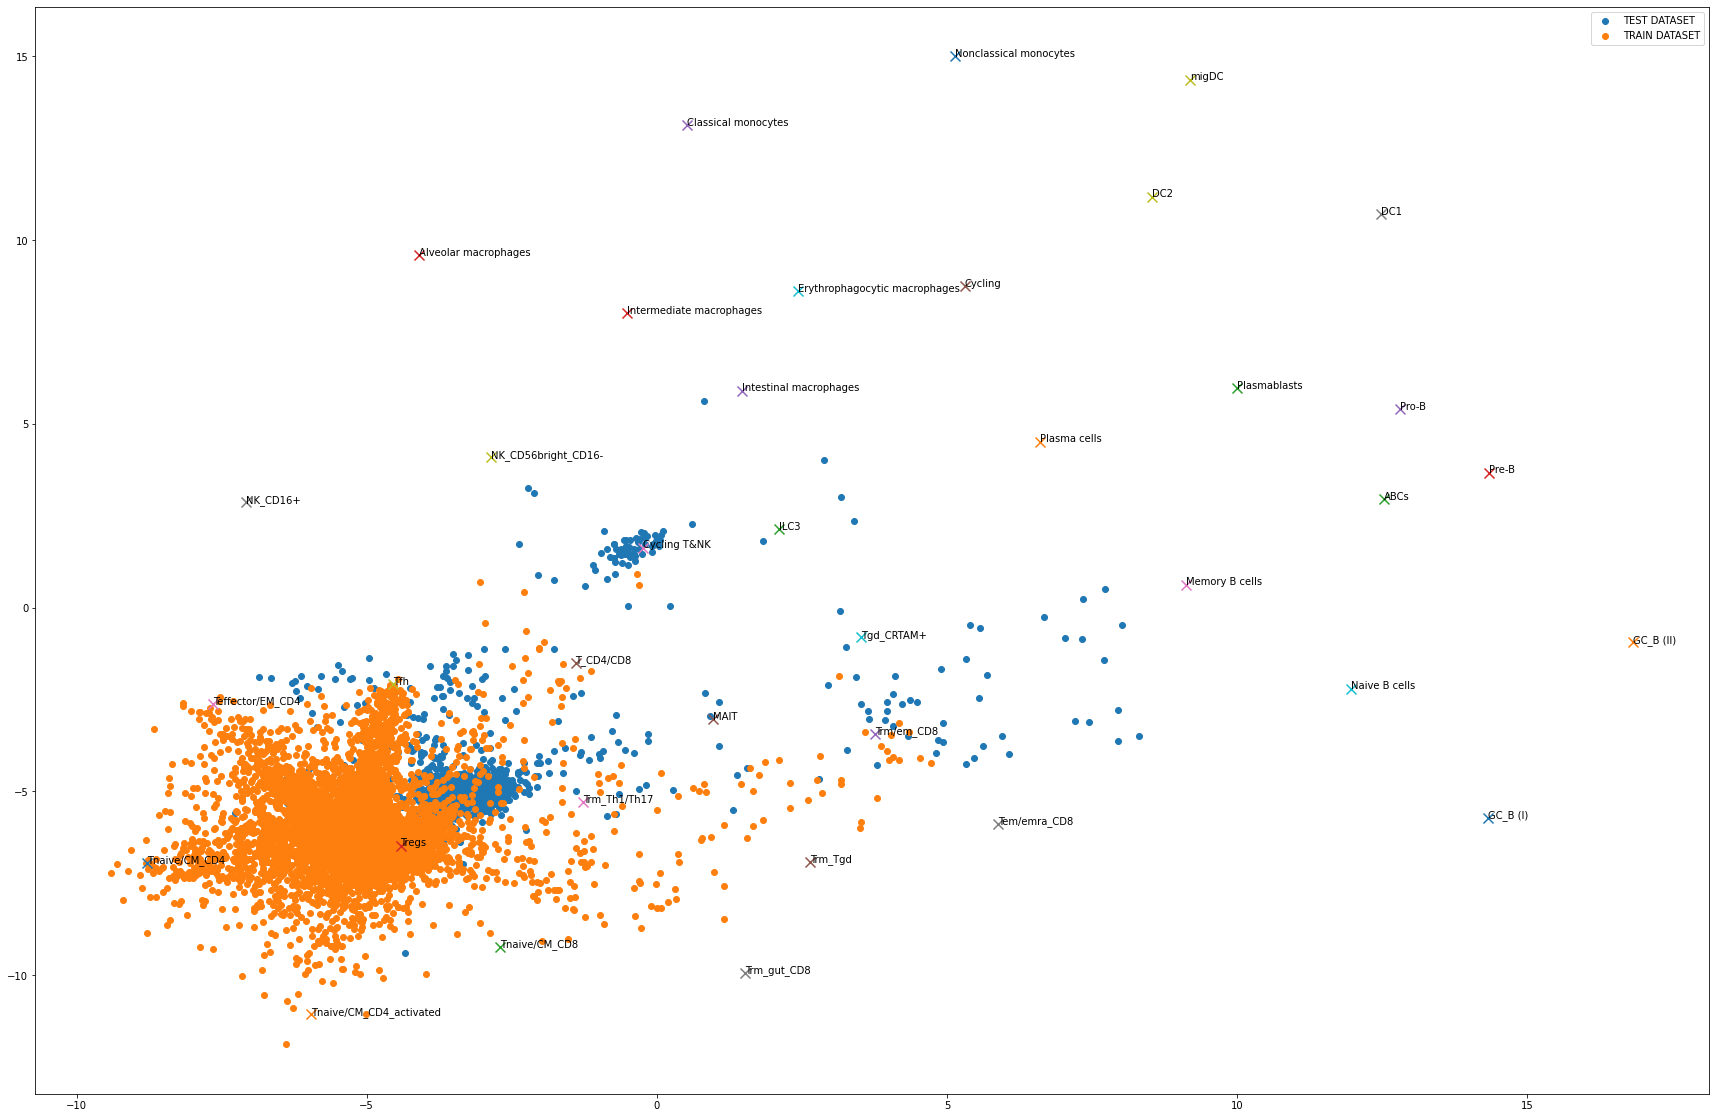

In [9]:
helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
 train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
 test_pred_labels=test_preds, train_celltype='Tregs', test_celltype='regulatory T cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

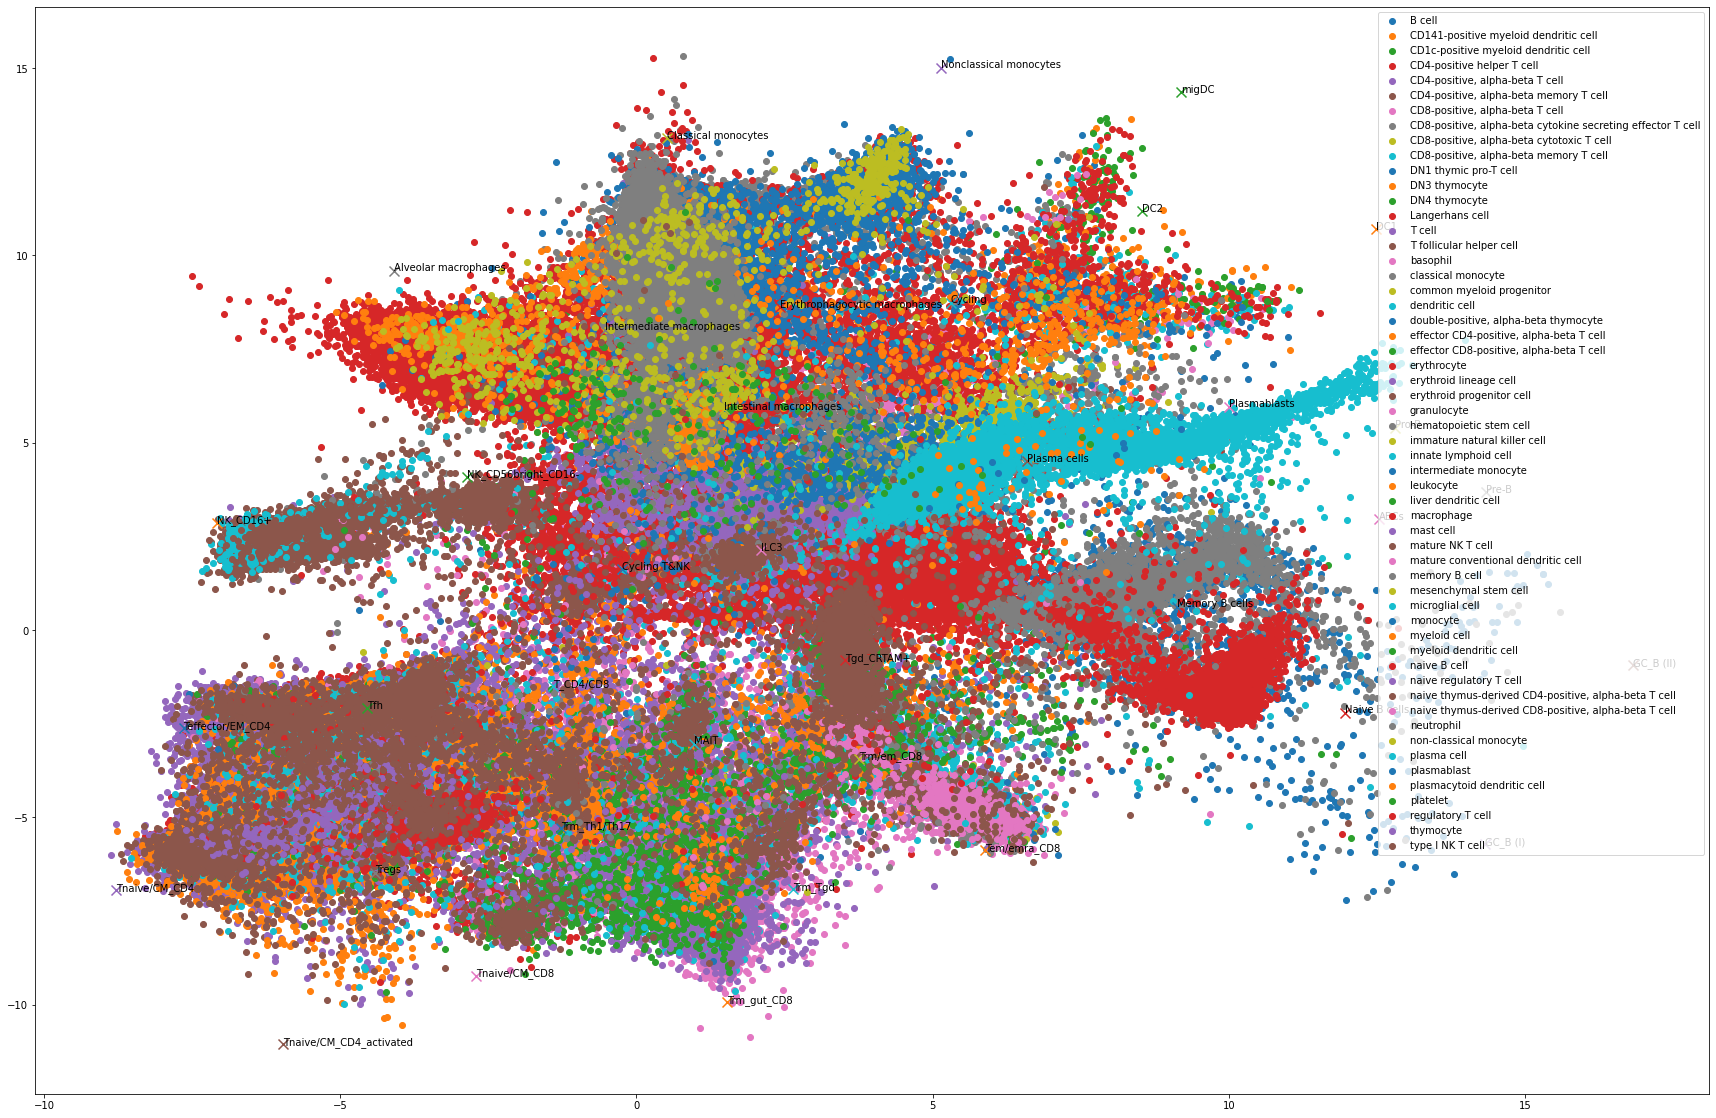

In [11]:
helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_popv_pca.obs['cell_type'], 
    embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

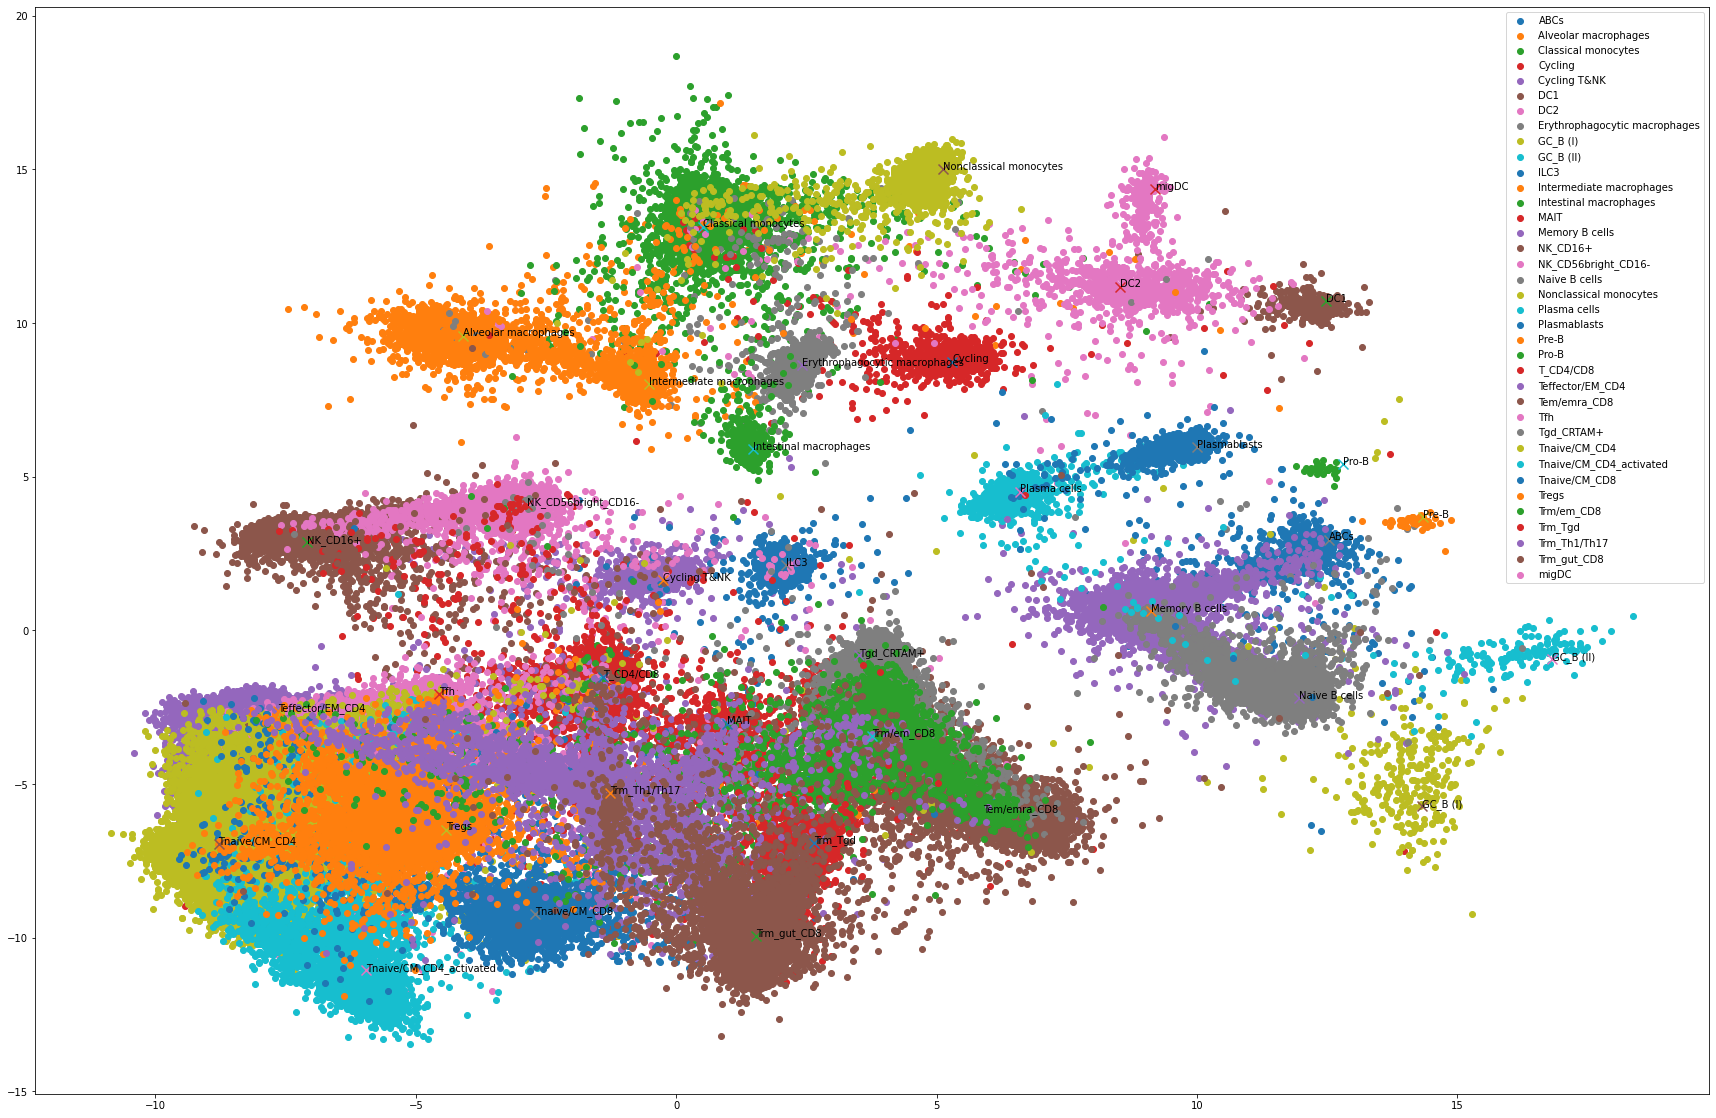

In [13]:
helper_fns.plot_embeddings_scatter(embeddings=train_embeddings, true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], 
    embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

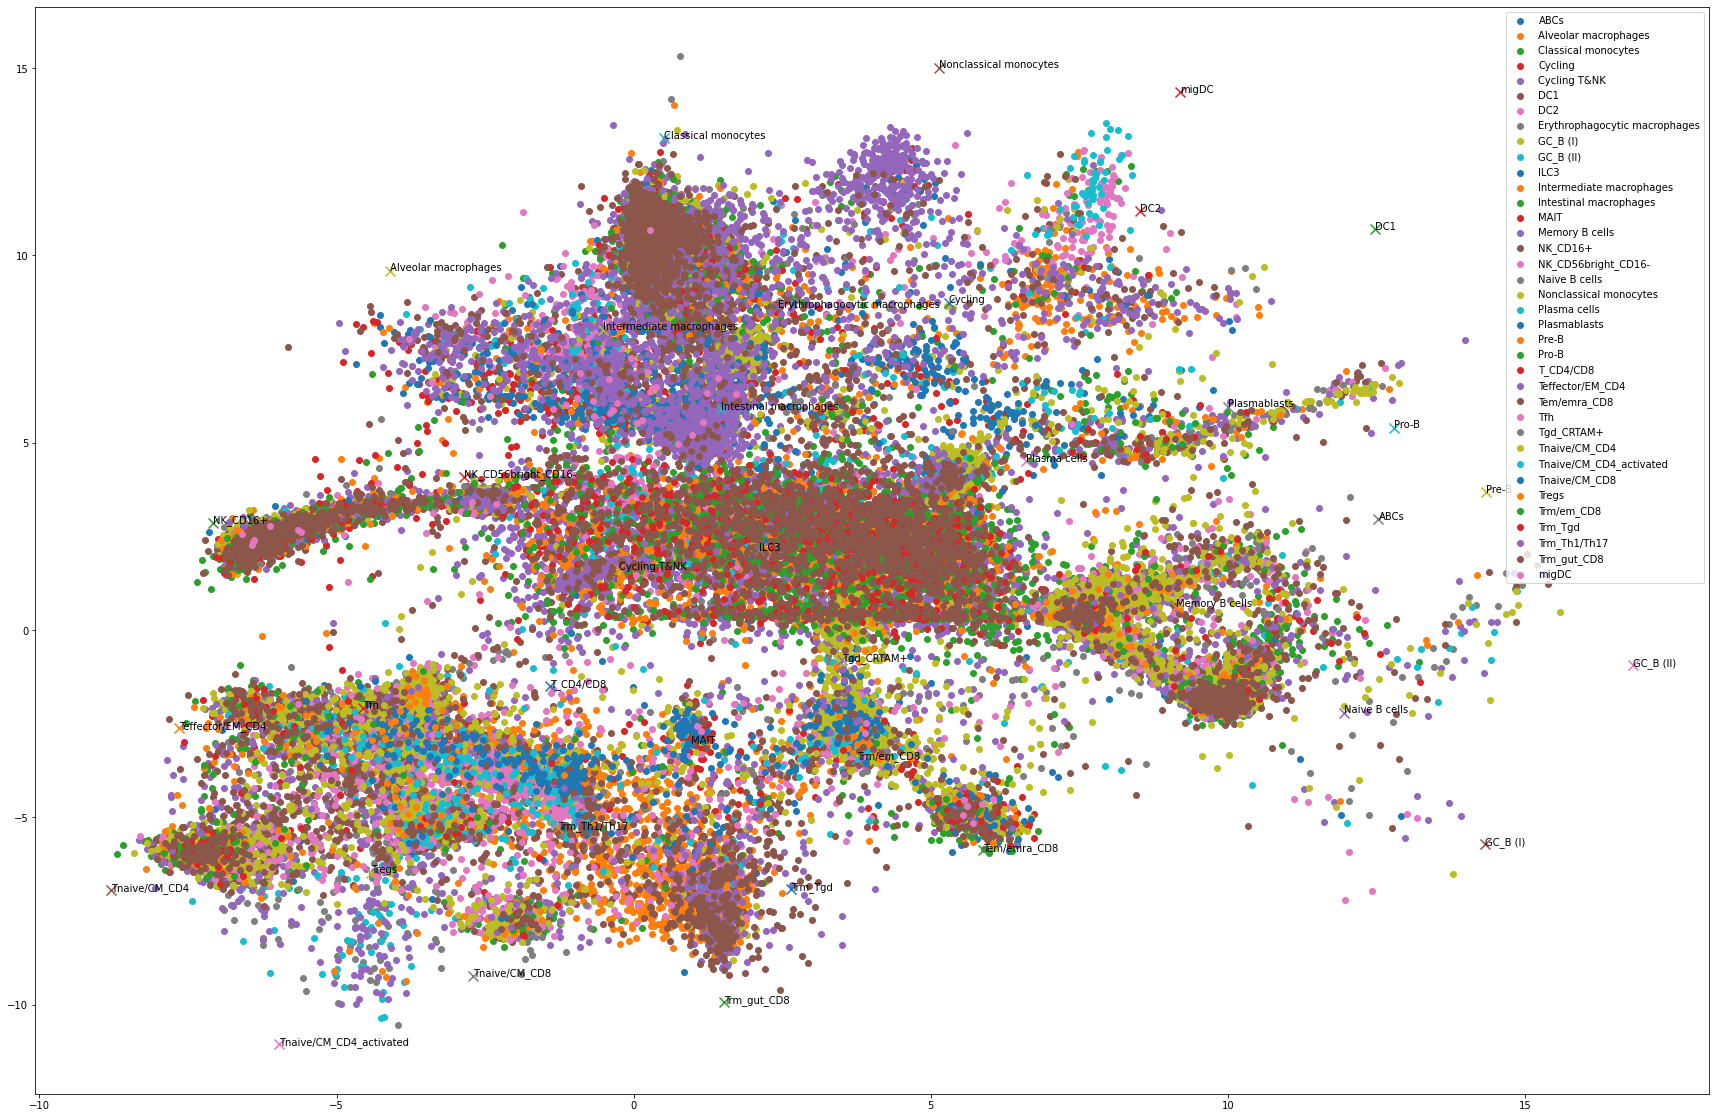

In [14]:
helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_celltypist_pca[test_indices].obs['Manually_curated_celltype'], 
    embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

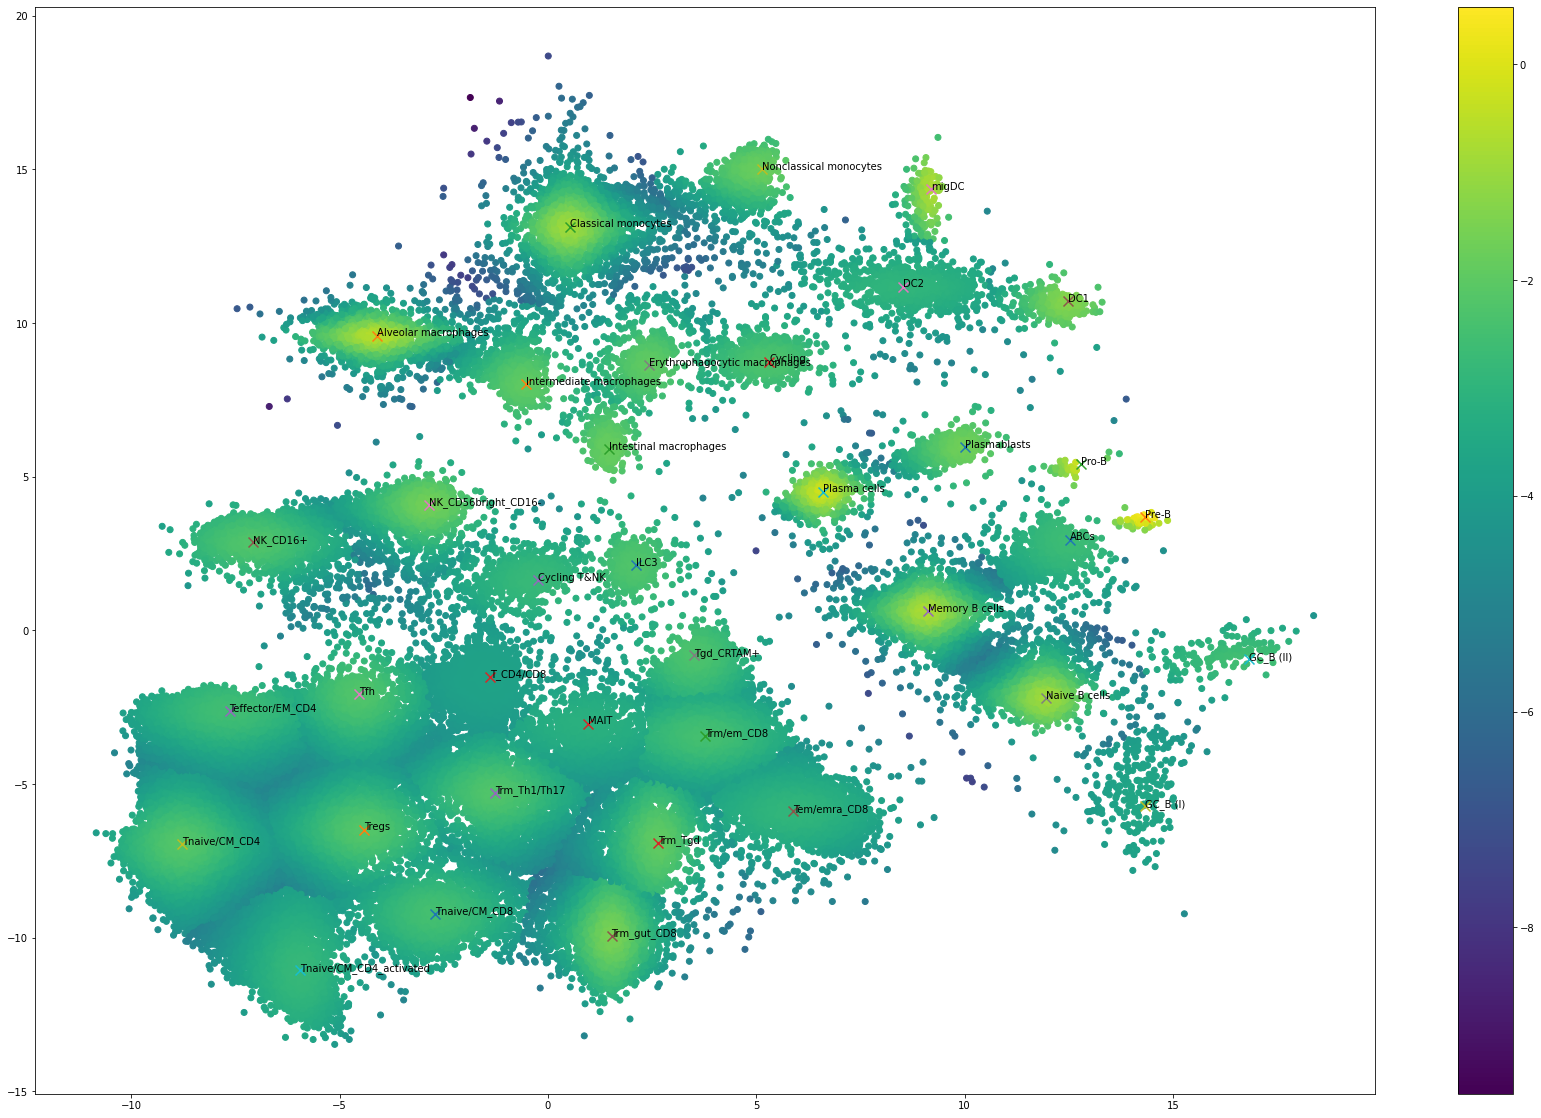

In [15]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=training_preds, 
    embeddings=train_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

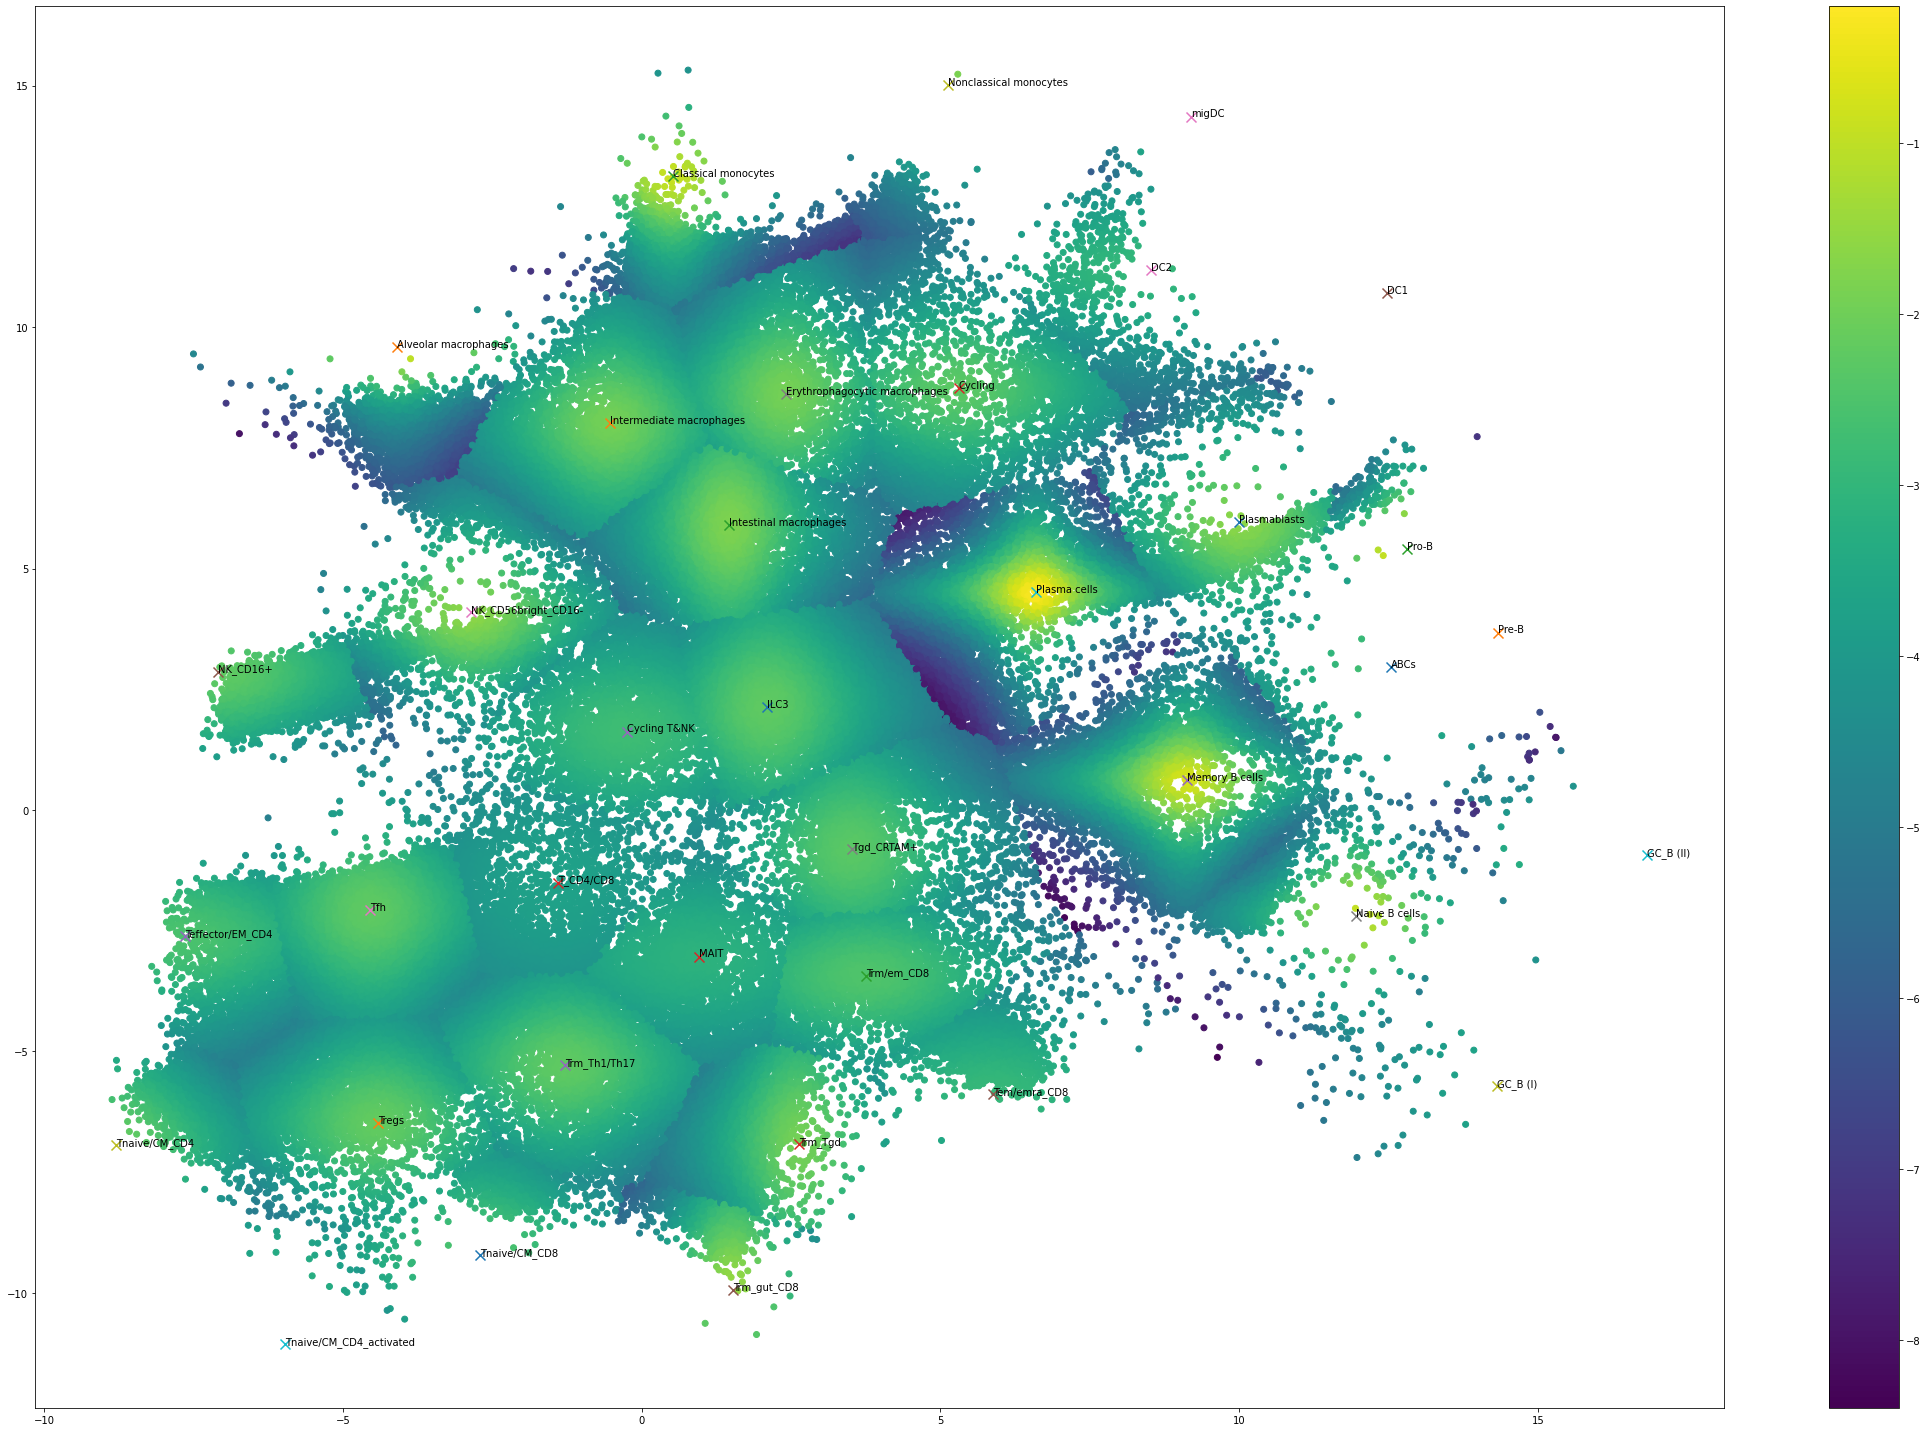

In [16]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=test_preds, 
    embeddings=test_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)